## Mock LSL EMG streaming data
Зная что частота дискретизации ЭМГ данных в нашей записи не превосходит 5000Гц можно предположить что LSL потом посылает данные на большей частате, а значит мы будем послылать данные из заготовленных данных каждые 1/5000 с.

In [2]:
%matplotlib qt5
%config Completer.use_jedi = False

import mne
import os
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import pylsl
import scipy
import matplotlib

from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier

from scipy.signal import find_peaks
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
# EVENT_NAMES = {'Pronation': 10001, 'Supination': 10003, 'Elbow flexion': 10004, 'Elbow extension': 10005,
#               'Wrist flexion': 10006, 'Wrist extension': 10007, 'Fist closing': 10009, 'Fist opening': 10010,
#               'Precise grip closing': 10011, 'Precise grip opening': 10012, 'Pointing grip closing': 10013,
#               'Pointing grip opening': 10014, 'Rest state': 10015, 'Thumb to center': 10016, 'Thumb to lateral': 10017}
EVENT_NAMES = {'Elbow flexion': 10001, 'Elbow extension': 10002}
WINDOW_SIZE = 10000 #samples
INTERSECTION = 500 #samples
BANDPASS_LIMITS = (20, 800)
FREQUENCY_SAMPLING = 5000
CHANNEL_NUMBER = 5 # for leg 12

In [4]:
test_X = voltages[0]
# plt.plot(test_X)
b, a = scipy.signal.butter(4, [BANDPASS_LIMITS[0], BANDPASS_LIMITS[1]], fs=FREQUENCY_SAMPLING, btype='bandpass')
test_X = scipy.signal.lfilter(b, a, test_X)
# plt.plot(test_X)
test_X = np.abs(scipy.signal.hilbert(test_X, axis=0))
plt.plot(test_X)
test_X = scipy.signal.resample(test_X, int(test_X.shape[1] / FREQUENCY_SAMPLING * 30), axis=1)
plt.plot(test_X)

NameError: name 'voltages' is not defined

In [ ]:
test_X.shape[0]

In [52]:
# Filtering setup
def preproces(x):
    b, a = scipy.signal.butter(4, [BANDPASS_LIMITS[0], BANDPASS_LIMITS[1]], fs=FREQUENCY_SAMPLING, btype='bandpass')
    x = scipy.signal.lfilter(b, a, x)
    # plt.plot(x[0])
    # print(x.shape)
    x = np.abs(scipy.signal.hilbert(x, axis=0))
    # plt.plot(x[0])
    # print(x.shape)
    x = scipy.signal.resample(x, int(x.shape[1] / FREQUENCY_SAMPLING * 30), axis=1)
    # plt.plot(x[0])
    # print(x.shape)
    plt.show()
    return x

In [6]:
def shift(arr, num, fill_value=np.nan):
    result = np.empty_like(arr)
    if num > 0:
        result[:num] = fill_value
        result[num:] = arr[:-num]
    elif num < 0:
        result[num:] = fill_value
        result[:num] = arr[-num:]
    else:
        result[:] = arr
    return result

arr = np.arange(2000).astype(float)
shift(arr, -200)

array([200., 201., 202., ...,  nan,  nan,  nan])

## Model learning
We using stacking classifier SVM + Logistic regression, using features extracted from PCA

In [7]:
# Loading data
# raw=mne.io.read_raw_brainvision('Server_LSL/test_data/NeoRec_2022-11-03_11-57-36.vhdr', preload=True)
raw=mne.io.read_raw_brainvision('Data/test/NeoRec_2023-01-20_17-00-10.vhdr', preload=True)
events=mne.events_from_annotations(raw)[0]
raw = raw.pick_channels([f"EMG_{i}" for i in range(6, 11)])
raw_envelope = raw.copy().filter(BANDPASS_LIMITS[0], BANDPASS_LIMITS[1]).apply_hilbert(envelope=True)
# raw_envelope = raw.copy().apply_hilbert(envelope=True)
raw_envelope, events_env = raw_envelope.resample(30, events=events, n_jobs=8)

Extracting parameters from Data/test/NeoRec_2023-01-20_17-00-10.vhdr...
Setting channel info structure...
Reading 0 ... 461114  =      0.000 ...    92.223 secs...
Used Annotations descriptions: ['3/Event 1', '3/Event 2', 'New Segment/']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 20 - 8e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 20.00
- Lower transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 17.50 Hz)
- Upper passband edge: 800.00 Hz
- Upper transition bandwidth: 200.00 Hz (-6 dB cutoff frequency: 900.00 Hz)
- Filter length: 3301 samples (0.660 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:    1.9s remaining:    2.9s
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:    2.0s finished


In [8]:
# Epoching
epochs = mne.Epochs(raw_envelope, events=events_env, tmin=0, tmax=2, event_id = EVENT_NAMES, preload=True, baseline=None)
X=[]
for i in range(epochs._data.shape[0]):
    channel_names = np.arange(CHANNEL_NUMBER).astype(str).tolist()
    channel_types = ['emg']*CHANNEL_NUMBER
    info = mne.create_info(channel_names, FREQUENCY_SAMPLING, channel_types)
    raw = mne.io.RawArray(epochs._data[i], info, verbose=False)
    # raw.filter(0, BANDPASS_LIMITS[1], picks=['emg'], n_jobs=4)
    x__=[]

    # Append PCA of epoch data
    x__ = [*x__, *epochs._data[i][:, :-1].flatten().reshape(1,-1)]
    # Отрисовать метрики
    X.append(x__)
pca = PCA(5)
# X = np.array(X)
X = np.array(X).squeeze()
pca = pca.fit(X)
pv = pca.transform(X)
y = epochs.events[:,-1].flatten()

Not setting metadata
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Loading data for 20 events and 61 original time points ...
0 bad epochs dropped


In [9]:
X = np.array(X)
X.shape

(20, 300)

In [10]:
svc = SVC(C=0.9, kernel='rbf', probability=True)
lr = LogisticRegression(max_iter=1000, n_jobs=4)
classifier=StackingClassifier([('SVC', svc), ('Logistic regression', lr)])
classifier.fit(pv, y)
display(classifier.score(pv, y))

1.0

In [91]:
plt.plot(X[0])

In [44]:
plt.ion()
fig = plt.figure()
ax = fig.add_subplot(111)
# ax.set_xlim((1674208878.5875, 1674208978.5875))
# ax.set_ylim((0, 5e-2))
# ax.autoscale()

mock_stream=pylsl.resolve_streams()[1]
stream_inlet=pylsl.StreamInlet(mock_stream)
# voltages, timestamps = np.zeros((CHANNEL_NUMBER, WINDOW_SIZE)), np.zeros(WINDOW_SIZE)
voltages, timestamps = [0], [0]
line = ax.plot([0, 0], [0, 0])[0]
t0 = stream_inlet.pull_sample()[1]
ax.set_xlim((t0, t0+2))
ax.set_ylim((-5e-4, 5e-4))
print(f't0: {t0}')

i=0
while True:
    if i % 100 == 0:
        values, timestamp = stream_inlet.pull_sample()
        if timestamp < timestamps[-1]:
            continue
        voltages.append(values[9])
        timestamps.append(timestamp)
        line.set_xdata(timestamps)
        line.set_ydata(voltages)
        # print(values)
        fig.canvas.draw()
        fig.canvas.flush_events()
        i=0
    i+=1

t0: 1674228004.141


KeyboardInterrupt: 

In [ ]:
plt.xlim(timestamps[1]-1, timestamps[-1]+1)
plt.plot(timestamps, voltages)

In [76]:
components=np.array(components)
for i in range(5):
    plt.plot(components[:, :, i])

In [57]:
components.shape

(110, 1, 5)

In [25]:
a=pylsl.resolve_streams()
[a[i].name() for i in range(len(a))]

['NVX52_Data', 'NVX52_Data', 'NVX52_Events', 'NVX52_Events']

In [62]:
plt.close()

In [65]:
# plot settings
plt.ion()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim((0, 500))
ax.set_ylim(10000, 10003)
components=[]
mock_stream=pylsl.resolve_streams()[1]
stream_inlet=pylsl.StreamInlet(mock_stream)
voltages, timestamps = np.zeros((CHANNEL_NUMBER, WINDOW_SIZE)), np.zeros(WINDOW_SIZE)
line = ax.plot([0, 0], [0, 0])[0]
t0 = stream_inlet.pull_sample()[1]

# First window filling
start = time.time()
i = 0
while True:
    # i_got, timestamp = stream_inlet.pull_sample()
    values, timestamp = stream_inlet.pull_sample()
    if i == WINDOW_SIZE - 1:
        break
    if values[0] != []:
        i += 1
        voltages[:, i] = values[6:11]
        timestamps[i] = timestamp - t0
print(time.time() - start)

i = INTERSECTION
stamps = []
j = 0
predictions = []
real_label = []
while True:
    # i_got, timestamp = stream_inlet.pull_sample()
    if i >= INTERSECTION:
        j+=1
        stamps.append(j)
        voltages_envelope = preproces(voltages)
        voltages_envelope = voltages_envelope.reshape(1, -1)
        pv = pca.transform(voltages_envelope)
        components.append(pv)
        # predictions.append(classifier.predict(pv))
        # real_label.append(i_got[0])
        # print(f"Prediction: {classifier.predict(pv)}, real label: {i_got[0]}")
        p = classifier.predict(pv)
        predictions.append(p[0])
        #stamps.append(j)
        print(f"Prediction: {p}")
        voltages = np.roll(voltages, -INTERSECTION)
        timestamps = np.roll(timestamps, -INTERSECTION)
        i = 0
        line.set_xdata(stamps)
        line.set_ydata(predictions)
        fig.canvas.draw()
        fig.canvas.flush_events()
    i += 1
    values, timestamp = stream_inlet.pull_sample()
    voltages[:, -INTERSECTION + i - 1] = values[5:10]
    timestamps[-INTERSECTION + i - 1] = timestamp
    # line.set_xdata(timestamps)
    # line.set_ydata(voltages[0, :])
    # fig.canvas.draw()
    # fig.canvas.flush_events()
    

1.8660142421722412
Prediction: [10002]
Prediction: [10002]
Prediction: [10002]
Prediction: [10002]
Prediction: [10002]
Prediction: [10002]
Prediction: [10002]
Prediction: [10002]
Prediction: [10002]
Prediction: [10002]
Prediction: [10002]
Prediction: [10002]
Prediction: [10002]
Prediction: [10002]
Prediction: [10002]
Prediction: [10002]
Prediction: [10002]
Prediction: [10002]
Prediction: [10002]
Prediction: [10002]
Prediction: [10002]
Prediction: [10002]
Prediction: [10002]
Prediction: [10002]
Prediction: [10002]
Prediction: [10002]
Prediction: [10002]
Prediction: [10002]
Prediction: [10002]
Prediction: [10002]
Prediction: [10002]
Prediction: [10002]
Prediction: [10001]
Prediction: [10001]
Prediction: [10001]
Prediction: [10002]
Prediction: [10002]
Prediction: [10002]
Prediction: [10002]
Prediction: [10002]
Prediction: [10002]
Prediction: [10002]
Prediction: [10001]
Prediction: [10001]
Prediction: [10001]
Prediction: [10001]
Prediction: [10001]
Prediction: [10002]
Prediction: [10002]
P

KeyboardInterrupt: 

In [56]:
predictions

[10002, 10002]

In [57]:
stamps

[1, 1, 2, 2]

In [50]:
plt.plot(voltages.T)

In [49]:
voltages.shape
preproces(voltages)

array([[9.40290638e-05, 7.67589039e-05, 6.70586899e-05, 4.60891207e-05,
        9.14922837e-05, 7.48532916e-05, 7.21036728e-05, 1.26824380e-04,
        1.44321932e-04, 1.10539152e-04, 1.67510177e-04, 9.43186935e-05,
        1.59245810e-04, 1.65703273e-04, 1.08373664e-04, 9.58683217e-05,
        1.22979108e-04, 9.28290147e-05, 8.38422128e-05, 1.14408071e-04,
        9.48987127e-05, 6.56226862e-05, 1.04089375e-04, 7.01122625e-05,
        7.51546948e-05, 8.85958352e-05, 7.38845421e-05, 9.42399553e-05,
        4.80934809e-05, 6.92809901e-05, 8.08477475e-05, 3.80846975e-05,
        7.61470221e-05, 6.93701765e-05, 3.32362353e-05, 7.74514984e-05,
        3.17260086e-05, 6.80952358e-05, 3.94073513e-05, 5.88642687e-05,
        4.35378155e-05, 4.87658246e-05, 7.60721153e-05, 2.19990944e-05,
        7.31255309e-05, 1.82917367e-05, 8.32691422e-05, 5.40696455e-05,
        4.34913949e-05, 6.33519778e-05, 6.90394375e-05, 6.08801790e-05,
        4.72070501e-05, 6.96515733e-05, 3.09562371e-05, 6.634107

In [95]:
plt.plot(voltages[0])

In [89]:
voltages_envelope

array([[ 9.29560130e+00,  8.85794720e+00,  8.87195898e-01,
         9.85626579e-01, -3.59805975e-01,  3.54864161e-01,
        -2.65299614e-01,  2.20331504e-01, -1.81456625e-01,
         1.52393949e-01, -1.28190012e-01,  1.08344585e-01,
        -9.12338629e-02,  7.69620181e-02, -6.36161370e-02,
         5.25816450e-02, -4.20955417e-02,  3.30976888e-02,
        -2.43701830e-02,  1.66331589e-02, -8.87288233e-03,
         2.34757863e-03,  4.58769743e-03, -1.05116476e-02,
         1.67279966e-02, -2.22406538e-02,  2.82421491e-02,
        -3.34566393e-02,  3.91171929e-02, -4.42089200e-02,
         4.97392232e-02, -5.47595525e-02,  6.04386337e-02,
        -6.55219318e-02,  7.12985888e-02, -7.65591999e-02,
         8.25334154e-02, -8.82908521e-02,  9.46799902e-02,
        -1.00877579e-01,  1.07929495e-01, -1.14925115e-01,
         1.22769409e-01, -1.30926041e-01,  1.40112135e-01,
        -1.49887416e-01,  1.60991266e-01, -1.73194029e-01,
         1.87209985e-01, -2.03238410e-01,  2.22139470e-0

In [24]:
plt.xlim(timestamps[1]-1, timestamps[-1]+1)
plt.plot(timestamps, voltages[1, :])

In [16]:
voltages[0, :]

array([-0.00590781, -0.00587075, -0.0058561 , ..., -0.01620874,
       -0.01621944, -0.01622129])

In [11]:
plt.plot(real_label)

Using matplotlib as 2D backend.


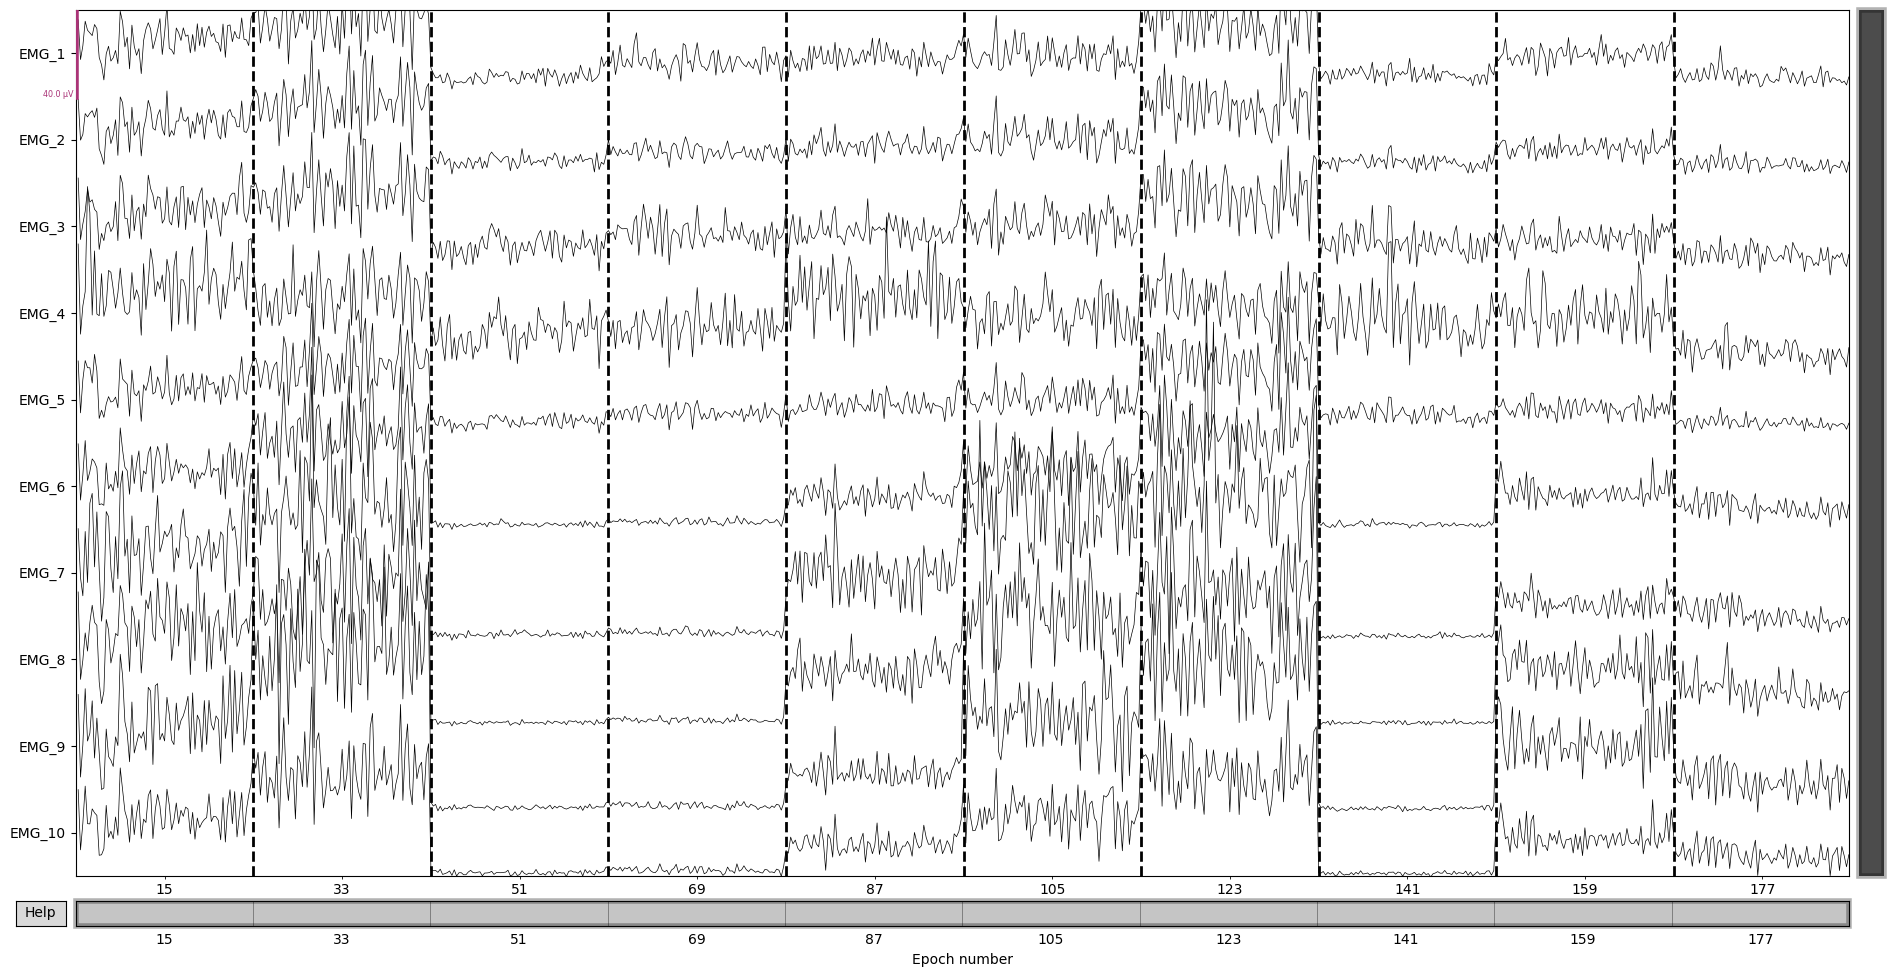

Dropped 0 epochs: 
Channels marked as bad: none


In [16]:
epochs['10015'].plot()

In [ ]:
plt.plot(voltages_envelope[0])

In [16]:
voltages_envelope.shape

(1, 750)

In [33]:
a = np.arange(10)
a = np.roll(a, -5)
b = np.arange(100, 150)
display(a)
for i in range(1, 5+1):
    a[-5 + i-1] = b[i-1]

array([5, 6, 7, 8, 9, 0, 1, 2, 3, 4])

In [34]:
display(a)

array([  5,   6,   7,   8,   9, 100, 101, 102, 103, 104])

In [ ]:
a = np.arange(10, dtype=float)
a = shift(a, -5)
a

# Renaming events
Для того чтобы мы могли корректно обучить модель, метки необходимо реорганизовать. Во время 
эксперимента мы посылали метку с одним и тем же ID на сгибание, нейтральной положение и разгибание, следующее движение имело другой ID например: Пронация --> нейтральной положение --> супинация --> сгибание локтя --> разгибание локтя; Event_1 --> Event_1 --> Event_1 --> Event_2 --> Event_2; Нужно в ручную сделать различыми событиями например Event_1 --> Event_100 --> Event_10 --> Event_2 --> Event_20

In [7]:
def rename_events(event_filename, dir_name):
    events_file = open(event_filename)
    lines = events_file.readlines()
    delim = ','
    # print(lines)
    lines_to_write = list(lines)
    for event_number in range(1, 9):
        counter = 0
        for i in range(8, len(lines)):
            content = lines[i].split(',')
            content_prev = lines[i - 1].split(',')
            if content[1] == content_prev[1] and int(content[1][-1]) == event_number:
                counter += 1
                if event_number == 1 or event_number == 3:
                    if counter == 2:
                        content[1] += '0'
                        lines_to_write[i] = delim.join(content)
                        counter = 0
                    elif counter == 1:
                        content[1] += '00'
                        lines_to_write[i] = delim.join(content)
                elif event_number != 1 and event_number != 3:
                    if counter == 1:
                        content[1] += '0'
                        lines_to_write[i] = delim.join(content)
                        counter = 0
    events_file = open(f'Data_copy/{dir_name}/' + event_filename.split('/')[-1], 'w')
    events_file.writelines(lines_to_write)
    events_file.close()

In [5]:
events_files = list(filter(lambda filename: 'vmrk' in filename, os.listdir('Data/Nikita_03_11_2022')))

In [51]:
events_files

['NeoRec_2022-11-03_11-41-19.vmrk',
 'NeoRec_2022-11-03_11-57-36.vmrk',
 'NeoRec_2022-11-03_12-16-31.vmrk',
 'NeoRec_2022-11-03_12-28-20.vmrk',
 'NeoRec_2022-11-03_12-43-44.vmrk']

## Offline classification for report
1. Cчитываем все файлы из директории с данными испытуемого и создаем единый объект Raw с помощью объединения 5 последовательных записей
2. Нарезаем данные на эпохи от 0 до 2с с соотвествующими индексами

TO DO: можно выделить в два раза больше эпох покоя, так как метка покоя предявлялась дважды 10016 еvent - тоже покой. Таким образом если поменять номер события внутри vmrk на тот же что и у event 10015, можно собрать больше данных для обучения

3. Обучаем несколько моделей и сравниваем данных на них

TO DO: нужно опробывать различные фичи, которые могут использовать для обучения моделей вместо PCA, на примере статьи (https://doi.org/10.1007/s11517-019-02073-z)

In [8]:
dir_name = 'Sergey_12_12_2022'
events_files = list(filter(lambda filename: 'vmrk' in filename, os.listdir(f'Data/{dir_name}')))
raws = []
events_list = []
for i, events_file in enumerate(events_files):
    rename_events(f'Data/{dir_name}/{events_files[i]}', dir_name)
    raw=mne.io.read_raw_brainvision(f'Data_copy/{dir_name}/{events_files[i][:-5]}.vhdr', preload=True)
    events=mne.events_from_annotations(raw)[0]
    # raw.drop_channels(['X', 'Y', 'Z', 'EMG_11', 'EMG_12', 'EMG_13', 'EMG_14', 'EMG_15', 'EMG_16'])
    raw.drop_channels(['EMG_11', 'EMG_12'])
    raw_envelope = raw.copy().filter(BANDPASS_LIMITS[0], BANDPASS_LIMITS[1]).apply_hilbert(envelope=True)
    # raw_envelope = raw.copy().apply_hilbert(envelope=True)
    raw_envelope, events_env = raw_envelope.resample(30, events=events, n_jobs=8)
    raws.append(raw_envelope)
    events_list.append(events_env)
raw_common = mne.concatenate_raws(raws, preload=True, events_list=events_list)

Extracting parameters from Data_copy/Sergey_12_12_2022/NeoRec_2022-12-12_15-58-45.vhdr...
Setting channel info structure...
Reading 0 ... 3374624  =      0.000 ...   674.925 secs...
Used Annotations descriptions: ['3/Event 1', '3/Event 10', '3/Event 100', '3/Event 2', '3/Event 20', '3/Event 3', '3/Event 30', '3/Event 300', '3/Event 4', '3/Event 40', '3/Event 5', '3/Event 50', '3/Event 6', '3/Event 60', '3/Event 7', '3/Event 70', '3/Event 8', '3/Event 80', 'New Segment/']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 20 - 1e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 20.00
- Lower transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 17.50 Hz)
- Upper passband edge: 1000.00 Hz
- Upper transition bandwidth: 250.00 Hz (-6 dB cutoff frequency: 1125

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    3.5s remaining:    2.3s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    3.7s finished


Extracting parameters from Data_copy/Sergey_12_12_2022/NeoRec_2022-12-12_16-12-11.vhdr...
Setting channel info structure...
Reading 0 ... 3386959  =      0.000 ...   677.392 secs...
Used Annotations descriptions: ['3/Event 1', '3/Event 10', '3/Event 100', '3/Event 2', '3/Event 20', '3/Event 3', '3/Event 30', '3/Event 300', '3/Event 4', '3/Event 40', '3/Event 5', '3/Event 50', '3/Event 6', '3/Event 60', '3/Event 7', '3/Event 70', '3/Event 8', '3/Event 80', 'New Segment/']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 20 - 1e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 20.00
- Lower transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 17.50 Hz)
- Upper passband edge: 1000.00 Hz
- Upper transition bandwidth: 250.00 Hz (-6 dB cutoff frequency: 1125

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    1.2s remaining:    0.7s


Extracting parameters from Data_copy/Sergey_12_12_2022/NeoRec_2022-12-12_16-26-30.vhdr...
Setting channel info structure...


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    1.7s finished


Reading 0 ... 3373189  =      0.000 ...   674.638 secs...
Used Annotations descriptions: ['3/Event 1', '3/Event 10', '3/Event 100', '3/Event 2', '3/Event 20', '3/Event 3', '3/Event 30', '3/Event 300', '3/Event 4', '3/Event 40', '3/Event 5', '3/Event 50', '3/Event 6', '3/Event 60', '3/Event 7', '3/Event 70', '3/Event 8', '3/Event 80', 'New Segment/']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 20 - 1e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 20.00
- Lower transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 17.50 Hz)
- Upper passband edge: 1000.00 Hz
- Upper transition bandwidth: 250.00 Hz (-6 dB cutoff frequency: 1125.00 Hz)
- Filter length: 3301 samples (0.660 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    1.1s remaining:    0.7s


Extracting parameters from Data_copy/Sergey_12_12_2022/NeoRec_2022-12-12_16-42-58.vhdr...


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    1.6s finished


Setting channel info structure...
Reading 0 ... 3387664  =      0.000 ...   677.533 secs...
Used Annotations descriptions: ['3/Event 1', '3/Event 10', '3/Event 100', '3/Event 2', '3/Event 20', '3/Event 3', '3/Event 30', '3/Event 300', '3/Event 4', '3/Event 40', '3/Event 5', '3/Event 50', '3/Event 6', '3/Event 60', '3/Event 7', '3/Event 70', '3/Event 8', '3/Event 80', 'New Segment/']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 20 - 1e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 20.00
- Lower transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 17.50 Hz)
- Upper passband edge: 1000.00 Hz
- Upper transition bandwidth: 250.00 Hz (-6 dB cutoff frequency: 1125.00 Hz)
- Filter length: 3301 samples (0.660 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    1.0s remaining:    0.7s


Extracting parameters from Data_copy/Sergey_12_12_2022/NeoRec_2022-12-12_16-59-26.vhdr...
Setting channel info structure...
Reading 0 ... 3392289  =      0.000 ...   678.458 secs...


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    1.5s finished


Used Annotations descriptions: ['3/Event 1', '3/Event 10', '3/Event 100', '3/Event 2', '3/Event 20', '3/Event 3', '3/Event 30', '3/Event 300', '3/Event 4', '3/Event 40', '3/Event 5', '3/Event 50', '3/Event 6', '3/Event 60', '3/Event 7', '3/Event 70', '3/Event 8', '3/Event 80', 'New Segment/']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 20 - 1e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 20.00
- Lower transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 17.50 Hz)
- Upper passband edge: 1000.00 Hz
- Upper transition bandwidth: 250.00 Hz (-6 dB cutoff frequency: 1125.00 Hz)
- Filter length: 3301 samples (0.660 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    1.2s remaining:    0.8s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    1.7s finished


In [10]:
# Epoching
epochs = mne.Epochs(raw_common[0], 
                    events=raw_common[-1],
                    tmin=0, tmax=2,
                    event_id = [10001, 10003, 10004, 10005, 10006, 10008, 10009, 10010, 
                                10011, 10012, 10013, 10014, 10015, 10017, 10018],
                    # event_id = [10001, 10003, 10004, 10005, 10006, 10008, 10009, 10010, 
                    #             10011, 10012, 10014, 10015, 10017, 10018],
                    preload=True, 
                    baseline=None).apply_hilbert(envelope=True)
X=[]
for i in range(epochs._data.shape[0]):
    channel_names = np.arange(CHANNEL_NUMBER).astype(str).tolist()
    channel_types = ['emg']*CHANNEL_NUMBER
    info = mne.create_info(channel_names, FREQUENCY_SAMPLING, channel_types)
    raw = mne.io.RawArray(epochs._data[i], info, verbose=False)
    # raw.filter(BANDPASS_LIMITS[0], BANDPASS_LIMITS[1], picks=['emg'], n_jobs=4)
    x__=[]

    # Append PCA of epoch data
    x__ = [*x__, *epochs._data[i][:, :-1].flatten().reshape(1,-1)]
    # Отрисовать метрики
    X.append(x__)
pca = PCA(15)
X = np.array(X).squeeze()
pca = pca.fit(X)
pv = pca.transform(X)
y = epochs.events[:,-1].flatten()

Not setting metadata
Not setting metadata
752 matching events found
No baseline correction applied
0 projection items activated
Loading data for 752 events and 61 original time points ...
0 bad epochs dropped


In [30]:
pv.shape

(752, 15)

<ipython-input-56-c5fc4a38815d>:1: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  mne.viz.plot_events(events)


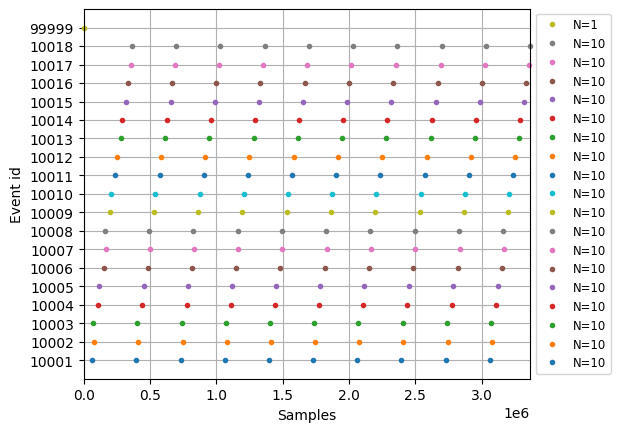

In [56]:
mne.viz.plot_events(events)

In [ ]:
EVENT_NAMES = {'Pronation': 10001, 'Supination': 10003, 'Elbow flexion': 10004, 'Elbow extension': 10005,
              'Wrist flexion': 10006, 'Wrist extension': 10007, 'Fist closing': 10009, 'Fist openning': 10010,
              'Precise grip closing': 10011, 'Precise grip openning': 10012, 'Pointing grip closing': 10013,
              'Pointing grip openning': 10014, 'Rest state': 10015, 'Thumb to center': 10017, 'Thumb to lateral': 10018}

In [31]:
accuracies = []
svc = SVC(C=0.8, kernel='rbf', probability=True)
lr = LogisticRegression(max_iter=1000, random_state=42)
# nn = MLPClassifier(max_iter=1000)
stacking_classifier=StackingClassifier([('SVC', svc), ('Logistic regression', lr)])
random_forest = RandomForestClassifier(bootstrap=True, max_depth=7, n_estimators=100, n_jobs=8)
classifiers = [random_forest, stacking_classifier, svc]
for classifier in classifiers:
    classifier.fit(pv, y)
    cv = cross_val_score(classifier, pv, y)
    display(cv)
    accuracies.append(cv)
#0.06914893617021277


array([0.66225166, 0.78807947, 0.77333333, 0.63333333, 0.71333333])

array([0.58940397, 0.62913907, 0.68666667, 0.57333333, 0.58666667])

array([0.58278146, 0.66225166, 0.65333333, 0.52666667, 0.52      ])

In [32]:
# svc = SVC(C=0.9, kernel='rbf', probability=True)
# svc.fit(pv, y)
# acuracies(svc.score(pv, y))
accuracies = np.array(accuracies)
plt.bar(x=np.linspace(1, 4, 3), height=accuracies.mean(axis=1), yerr=accuracies.std(axis=1))

<BarContainer object of 3 artists>

In [40]:
accuracies.mean(axis=1)

array([0.8324415 , 0.75146137, 0.67828698])

In [42]:
accuracies

array([[0.84768212, 0.82119205, 0.80666667, 0.82666667, 0.86      ],
       [0.73509934, 0.66887417, 0.73333333, 0.78      , 0.84      ],
       [0.66225166, 0.62251656, 0.70666667, 0.70666667, 0.69333333]])

0.06914893617021277

In [ ]:
accuracies = [0.77, 0.7699468085106383, 0.670549084858569]

## Эта часть обобщает результаты по всем испытуемым
Из нее можно взять ячейки с построением графиков предварительно подкорректировав код

In [4]:
dir_names = ['Sergey_12_12_2022', 'Ilya_9_12_2022']
raw_array = []
for dir_name in dir_names:
    events_files = list(filter(lambda filename: 'vmrk' in filename, os.listdir(f'Data/{dir_name}')))
    raws = []
    events_list = []
    for i, events_file in enumerate(events_files):
        rename_events(f'Data/{dir_name}/{events_files[i]}', dir_name)
        raw=mne.io.read_raw_brainvision(f'Data_copy/{dir_name}/{events_files[i][:-5]}.vhdr', preload=True)
        events=mne.events_from_annotations(raw)[0]
        # raw.drop_channels(['X', 'Y', 'Z', 'EMG_11', 'EMG_12', 'EMG_13', 'EMG_14', 'EMG_15', 'EMG_16'])
        raw.drop_channels(['EMG_11', 'EMG_12'])
        raw_envelope = raw.copy().filter(BANDPASS_LIMITS[0], BANDPASS_LIMITS[1]).apply_hilbert(envelope=True)
        # raw_envelope = raw.copy().apply_hilbert(envelope=True)
        raw_envelope, events_env = raw_envelope.resample(30, events=events, n_jobs=8)
        raws.append(raw_envelope)
        events_list.append(events_env)
    raw_common = mne.concatenate_raws(raws, preload=True, events_list=events_list)
    raw_array.append(raw_common)

Extracting parameters from Data_copy/Sergey_12_12_2022/NeoRec_2022-12-12_15-58-45.vhdr...
Setting channel info structure...
Reading 0 ... 3374624  =      0.000 ...   674.925 secs...
Used Annotations descriptions: ['3/Event 1', '3/Event 10', '3/Event 100', '3/Event 2', '3/Event 20', '3/Event 3', '3/Event 30', '3/Event 300', '3/Event 4', '3/Event 40', '3/Event 5', '3/Event 50', '3/Event 6', '3/Event 60', '3/Event 7', '3/Event 70', '3/Event 8', '3/Event 80', 'New Segment/']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2e+02 - 1e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 200.00
- Lower transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 175.00 Hz)
- Upper passband edge: 1000.00 Hz
- Upper transition bandwidth: 250.00 Hz (-6 dB cutoff frequency

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    3.5s remaining:    2.3s


Extracting parameters from Data_copy/Sergey_12_12_2022/NeoRec_2022-12-12_16-12-11.vhdr...
Setting channel info structure...
Reading 0 ... 3386959  =      0.000 ...   677.392 secs...


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    3.9s finished


Used Annotations descriptions: ['3/Event 1', '3/Event 10', '3/Event 100', '3/Event 2', '3/Event 20', '3/Event 3', '3/Event 30', '3/Event 300', '3/Event 4', '3/Event 40', '3/Event 5', '3/Event 50', '3/Event 6', '3/Event 60', '3/Event 7', '3/Event 70', '3/Event 8', '3/Event 80', 'New Segment/']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2e+02 - 1e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 200.00
- Lower transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 175.00 Hz)
- Upper passband edge: 1000.00 Hz
- Upper transition bandwidth: 250.00 Hz (-6 dB cutoff frequency: 1125.00 Hz)
- Filter length: 331 samples (0.066 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    1.2s remaining:    0.8s


Extracting parameters from Data_copy/Sergey_12_12_2022/NeoRec_2022-12-12_16-26-30.vhdr...
Setting channel info structure...
Reading 0 ... 3373189  =      0.000 ...   674.638 secs...


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    1.6s finished


Used Annotations descriptions: ['3/Event 1', '3/Event 10', '3/Event 100', '3/Event 2', '3/Event 20', '3/Event 3', '3/Event 30', '3/Event 300', '3/Event 4', '3/Event 40', '3/Event 5', '3/Event 50', '3/Event 6', '3/Event 60', '3/Event 7', '3/Event 70', '3/Event 8', '3/Event 80', 'New Segment/']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2e+02 - 1e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 200.00
- Lower transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 175.00 Hz)
- Upper passband edge: 1000.00 Hz
- Upper transition bandwidth: 250.00 Hz (-6 dB cutoff frequency: 1125.00 Hz)
- Filter length: 331 samples (0.066 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    1.3s remaining:    0.8s


Extracting parameters from Data_copy/Sergey_12_12_2022/NeoRec_2022-12-12_16-42-58.vhdr...
Setting channel info structure...
Reading 0 ... 3387664  =      0.000 ...   677.533 secs...


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    1.8s finished


Used Annotations descriptions: ['3/Event 1', '3/Event 10', '3/Event 100', '3/Event 2', '3/Event 20', '3/Event 3', '3/Event 30', '3/Event 300', '3/Event 4', '3/Event 40', '3/Event 5', '3/Event 50', '3/Event 6', '3/Event 60', '3/Event 7', '3/Event 70', '3/Event 8', '3/Event 80', 'New Segment/']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2e+02 - 1e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 200.00
- Lower transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 175.00 Hz)
- Upper passband edge: 1000.00 Hz
- Upper transition bandwidth: 250.00 Hz (-6 dB cutoff frequency: 1125.00 Hz)
- Filter length: 331 samples (0.066 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    1.2s remaining:    0.8s


Extracting parameters from Data_copy/Sergey_12_12_2022/NeoRec_2022-12-12_16-59-26.vhdr...
Setting channel info structure...
Reading 0 ... 3392289  =      0.000 ...   678.458 secs...


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    1.7s finished


Used Annotations descriptions: ['3/Event 1', '3/Event 10', '3/Event 100', '3/Event 2', '3/Event 20', '3/Event 3', '3/Event 30', '3/Event 300', '3/Event 4', '3/Event 40', '3/Event 5', '3/Event 50', '3/Event 6', '3/Event 60', '3/Event 7', '3/Event 70', '3/Event 8', '3/Event 80', 'New Segment/']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2e+02 - 1e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 200.00
- Lower transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 175.00 Hz)
- Upper passband edge: 1000.00 Hz
- Upper transition bandwidth: 250.00 Hz (-6 dB cutoff frequency: 1125.00 Hz)
- Filter length: 331 samples (0.066 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    1.1s remaining:    0.7s


Extracting parameters from Data_copy/Ilya_9_12_2022/NeoRec_2022-12-09_10-31-51.vhdr...
Setting channel info structure...
Reading 0 ... 3391784  =      0.000 ...   678.357 secs...


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    1.5s finished


Used Annotations descriptions: ['3/Event 1', '3/Event 10', '3/Event 100', '3/Event 2', '3/Event 20', '3/Event 3', '3/Event 30', '3/Event 300', '3/Event 4', '3/Event 40', '3/Event 5', '3/Event 50', '3/Event 6', '3/Event 60', '3/Event 7', '3/Event 70', '3/Event 8', '3/Event 80', 'New Segment/']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2e+02 - 1e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 200.00
- Lower transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 175.00 Hz)
- Upper passband edge: 1000.00 Hz
- Upper transition bandwidth: 250.00 Hz (-6 dB cutoff frequency: 1125.00 Hz)
- Filter length: 331 samples (0.066 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    1.2s remaining:    0.7s


Extracting parameters from Data_copy/Ilya_9_12_2022/NeoRec_2022-12-09_10-44-55.vhdr...
Setting channel info structure...
Reading 0 ... 10959  =      0.000 ...     2.192 secs...
Used Annotations descriptions: ['New Segment/']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2e+02 - 1e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    1.6s finished


- Lower passband edge: 200.00
- Lower transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 175.00 Hz)
- Upper passband edge: 1000.00 Hz
- Upper transition bandwidth: 250.00 Hz (-6 dB cutoff frequency: 1125.00 Hz)
- Filter length: 331 samples (0.066 sec)

Extracting parameters from Data_copy/Ilya_9_12_2022/NeoRec_2022-12-09_10-45-05.vhdr...
Setting channel info structure...
Reading 0 ... 3387925  =      0.000 ...   677.585 secs...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished


Used Annotations descriptions: ['3/Event 1', '3/Event 10', '3/Event 100', '3/Event 2', '3/Event 20', '3/Event 3', '3/Event 30', '3/Event 300', '3/Event 4', '3/Event 40', '3/Event 5', '3/Event 50', '3/Event 6', '3/Event 60', '3/Event 7', '3/Event 70', '3/Event 8', '3/Event 80', 'New Segment/']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2e+02 - 1e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 200.00
- Lower transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 175.00 Hz)
- Upper passband edge: 1000.00 Hz
- Upper transition bandwidth: 250.00 Hz (-6 dB cutoff frequency: 1125.00 Hz)
- Filter length: 331 samples (0.066 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    1.1s remaining:    0.7s


Extracting parameters from Data_copy/Ilya_9_12_2022/NeoRec_2022-12-09_11-07-12.vhdr...
Setting channel info structure...
Reading 0 ... 1600414  =      0.000 ...   320.083 secs...


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    1.6s finished


Used Annotations descriptions: ['3/Event 1', '3/Event 10', '3/Event 100', '3/Event 2', '3/Event 20', '3/Event 3', '3/Event 30', '3/Event 300', '3/Event 4', '3/Event 40', '3/Event 5', '3/Event 50', '3/Event 6', '3/Event 60', '3/Event 7', '3/Event 70', '3/Event 8', '3/Event 80', 'New Segment/']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2e+02 - 1e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 200.00
- Lower transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 175.00 Hz)
- Upper passband edge: 1000.00 Hz
- Upper transition bandwidth: 250.00 Hz (-6 dB cutoff frequency: 1125.00 Hz)
- Filter length: 331 samples (0.066 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.6s remaining:    0.4s


Extracting parameters from Data_copy/Ilya_9_12_2022/NeoRec_2022-12-09_11-14-41.vhdr...
Setting channel info structure...
Reading 0 ... 3332514  =      0.000 ...   666.503 secs...


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.9s finished


Used Annotations descriptions: ['3/Event 1', '3/Event 10', '3/Event 100', '3/Event 2', '3/Event 20', '3/Event 3', '3/Event 30', '3/Event 300', '3/Event 4', '3/Event 40', '3/Event 5', '3/Event 50', '3/Event 6', '3/Event 60', '3/Event 7', '3/Event 70', '3/Event 8', '3/Event 80', 'New Segment/']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2e+02 - 1e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 200.00
- Lower transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 175.00 Hz)
- Upper passband edge: 1000.00 Hz
- Upper transition bandwidth: 250.00 Hz (-6 dB cutoff frequency: 1125.00 Hz)
- Filter length: 331 samples (0.066 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    1.1s remaining:    0.7s


Extracting parameters from Data_copy/Ilya_9_12_2022/NeoRec_2022-12-09_11-26-24.vhdr...
Setting channel info structure...
Reading 0 ... 3376929  =      0.000 ...   675.386 secs...


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    1.6s finished


Used Annotations descriptions: ['3/Event 1', '3/Event 10', '3/Event 100', '3/Event 2', '3/Event 20', '3/Event 3', '3/Event 30', '3/Event 300', '3/Event 4', '3/Event 40', '3/Event 5', '3/Event 50', '3/Event 6', '3/Event 60', '3/Event 7', '3/Event 70', '3/Event 8', '3/Event 80', 'New Segment/']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2e+02 - 1e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 200.00
- Lower transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 175.00 Hz)
- Upper passband edge: 1000.00 Hz
- Upper transition bandwidth: 250.00 Hz (-6 dB cutoff frequency: 1125.00 Hz)
- Filter length: 331 samples (0.066 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    1.1s remaining:    0.7s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    1.6s finished


In [5]:
dir_names = ['Kolya_03_11_2022', 'Lev_02_11_2022', 'Nikita_03_11_2022', 'Sasha_14_11_2022']
for dir_name in dir_names:
    events_files = list(filter(lambda filename: 'vmrk' in filename, os.listdir(f'Data/{dir_name}')))
    raws = []
    events_list = []
    for i, events_file in enumerate(events_files):
        rename_events(f'Data/{dir_name}/{events_files[i]}', dir_name)
        raw=mne.io.read_raw_brainvision(f'Data_copy/{dir_name}/{events_files[i][:-5]}.vhdr', preload=True)
        events=mne.events_from_annotations(raw)[0]
        raw.drop_channels(['X', 'Y', 'Z', 'EMG_11', 'EMG_12', 'EMG_13', 'EMG_14', 'EMG_15', 'EMG_16'])
        # raw.drop_channels(['EMG_11', 'EMG_12'])
        raw_envelope = raw.copy().filter(BANDPASS_LIMITS[0], BANDPASS_LIMITS[1]).apply_hilbert(envelope=True)
        # raw_envelope = raw.copy().apply_hilbert(envelope=True)
        raw_envelope, events_env = raw_envelope.resample(30, events=events, n_jobs=8)
        raws.append(raw_envelope)
        events_list.append(events_env)
    raw_common = mne.concatenate_raws(raws, preload=True, events_list=events_list)
    raw_array.append(raw_common)

Extracting parameters from Data_copy/Kolya_03_11_2022/NeoRec_2022-11-03_10-12-53.vhdr...
Setting channel info structure...
Reading 0 ... 3366404  =      0.000 ...   673.281 secs...
Used Annotations descriptions: ['3/Event 1', '3/Event 10', '3/Event 100', '3/Event 2', '3/Event 20', '3/Event 3', '3/Event 30', '3/Event 300', '3/Event 4', '3/Event 40', '3/Event 5', '3/Event 50', '3/Event 6', '3/Event 60', '3/Event 7', '3/Event 70', '3/Event 8', '3/Event 80', 'New Segment/']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2e+02 - 1e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 200.00
- Lower transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 175.00 Hz)
- Upper passband edge: 1000.00 Hz
- Upper transition bandwidth: 250.00 Hz (-6 dB cutoff frequency:

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    1.1s remaining:    0.7s


Extracting parameters from Data_copy/Kolya_03_11_2022/NeoRec_2022-11-03_10-27-52.vhdr...


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    1.6s finished


Setting channel info structure...
Reading 0 ... 3399929  =      0.000 ...   679.986 secs...
Used Annotations descriptions: ['3/Event 1', '3/Event 10', '3/Event 100', '3/Event 2', '3/Event 20', '3/Event 3', '3/Event 30', '3/Event 300', '3/Event 4', '3/Event 40', '3/Event 5', '3/Event 50', '3/Event 6', '3/Event 60', '3/Event 7', '3/Event 70', '3/Event 8', '3/Event 80', 'New Segment/']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2e+02 - 1e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 200.00
- Lower transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 175.00 Hz)
- Upper passband edge: 1000.00 Hz
- Upper transition bandwidth: 250.00 Hz (-6 dB cutoff frequency: 1125.00 Hz)
- Filter length: 331 samples (0.066 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    1.1s remaining:    0.7s


Extracting parameters from Data_copy/Kolya_03_11_2022/NeoRec_2022-11-03_10-41-44.vhdr...
Setting channel info structure...
Reading 0 ... 3373174  =      0.000 ...   674.635 secs...


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    1.6s finished


Used Annotations descriptions: ['3/Event 1', '3/Event 10', '3/Event 100', '3/Event 2', '3/Event 20', '3/Event 3', '3/Event 30', '3/Event 300', '3/Event 4', '3/Event 40', '3/Event 5', '3/Event 50', '3/Event 6', '3/Event 60', '3/Event 7', '3/Event 70', '3/Event 8', '3/Event 80', 'New Segment/']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2e+02 - 1e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 200.00
- Lower transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 175.00 Hz)
- Upper passband edge: 1000.00 Hz
- Upper transition bandwidth: 250.00 Hz (-6 dB cutoff frequency: 1125.00 Hz)
- Filter length: 331 samples (0.066 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    1.4s remaining:    0.9s


Extracting parameters from Data_copy/Kolya_03_11_2022/NeoRec_2022-11-03_10-55-33.vhdr...
Setting channel info structure...
Reading 0 ... 3541529  =      0.000 ...   708.306 secs...


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    1.9s finished


Used Annotations descriptions: ['3/Event 1', '3/Event 10', '3/Event 100', '3/Event 2', '3/Event 20', '3/Event 3', '3/Event 30', '3/Event 300', '3/Event 4', '3/Event 40', '3/Event 5', '3/Event 50', '3/Event 6', '3/Event 60', '3/Event 7', '3/Event 70', '3/Event 8', '3/Event 80', 'New Segment/']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2e+02 - 1e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 200.00
- Lower transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 175.00 Hz)
- Upper passband edge: 1000.00 Hz
- Upper transition bandwidth: 250.00 Hz (-6 dB cutoff frequency: 1125.00 Hz)
- Filter length: 331 samples (0.066 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    1.3s remaining:    0.8s


Extracting parameters from Data_copy/Kolya_03_11_2022/NeoRec_2022-11-03_11-10-27.vhdr...
Setting channel info structure...
Reading 0 ... 3375766  =      0.000 ...   675.153 secs...


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    1.8s finished


Used Annotations descriptions: ['3/Event 1', '3/Event 10', '3/Event 100', '3/Event 2', '3/Event 20', '3/Event 3', '3/Event 30', '3/Event 300', '3/Event 4', '3/Event 40', '3/Event 5', '3/Event 50', '3/Event 6', '3/Event 60', '3/Event 7', '3/Event 70', '3/Event 8', '3/Event 80', 'New Segment/']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2e+02 - 1e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 200.00
- Lower transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 175.00 Hz)
- Upper passband edge: 1000.00 Hz
- Upper transition bandwidth: 250.00 Hz (-6 dB cutoff frequency: 1125.00 Hz)
- Filter length: 331 samples (0.066 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    1.1s remaining:    0.7s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    1.5s finished


Extracting parameters from Data_copy/Lev_02_11_2022/NeoRec_2022-11-02_17-42-08.vhdr...
Setting channel info structure...
Reading 0 ... 3400754  =      0.000 ...   680.151 secs...
Used Annotations descriptions: ['3/Event 1', '3/Event 10', '3/Event 100', '3/Event 2', '3/Event 20', '3/Event 3', '3/Event 30', '3/Event 300', '3/Event 4', '3/Event 40', '3/Event 5', '3/Event 50', '3/Event 6', '3/Event 60', '3/Event 7', '3/Event 70', '3/Event 8', '3/Event 80', 'New Segment/']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2e+02 - 1e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 200.00
- Lower transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 175.00 Hz)
- Upper passband edge: 1000.00 Hz
- Upper transition bandwidth: 250.00 Hz (-6 dB cutoff frequency: 1

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    1.1s remaining:    0.7s


Extracting parameters from Data_copy/Lev_02_11_2022/NeoRec_2022-11-02_17-56-05.vhdr...
Setting channel info structure...
Reading 0 ... 3431069  =      0.000 ...   686.214 secs...


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    1.5s finished


Used Annotations descriptions: ['3/Event 1', '3/Event 10', '3/Event 100', '3/Event 2', '3/Event 20', '3/Event 3', '3/Event 30', '3/Event 300', '3/Event 4', '3/Event 40', '3/Event 5', '3/Event 50', '3/Event 6', '3/Event 60', '3/Event 7', '3/Event 70', '3/Event 8', '3/Event 80', 'New Segment/']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2e+02 - 1e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 200.00
- Lower transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 175.00 Hz)
- Upper passband edge: 1000.00 Hz
- Upper transition bandwidth: 250.00 Hz (-6 dB cutoff frequency: 1125.00 Hz)
- Filter length: 331 samples (0.066 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    1.3s remaining:    0.8s


Extracting parameters from Data_copy/Lev_02_11_2022/NeoRec_2022-11-02_18-11-18.vhdr...
Setting channel info structure...
Reading 0 ... 3393720  =      0.000 ...   678.744 secs...


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    1.8s finished


Used Annotations descriptions: ['3/Event 1', '3/Event 10', '3/Event 100', '3/Event 2', '3/Event 20', '3/Event 3', '3/Event 30', '3/Event 300', '3/Event 4', '3/Event 40', '3/Event 5', '3/Event 50', '3/Event 6', '3/Event 60', '3/Event 7', '3/Event 70', '3/Event 8', '3/Event 80', 'New Segment/']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2e+02 - 1e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 200.00
- Lower transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 175.00 Hz)
- Upper passband edge: 1000.00 Hz
- Upper transition bandwidth: 250.00 Hz (-6 dB cutoff frequency: 1125.00 Hz)
- Filter length: 331 samples (0.066 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    1.1s remaining:    0.7s


Extracting parameters from Data_copy/Lev_02_11_2022/NeoRec_2022-11-02_18-24-33.vhdr...
Setting channel info structure...
Reading 0 ... 3391052  =      0.000 ...   678.210 secs...


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    1.6s finished


Used Annotations descriptions: ['3/Event 1', '3/Event 10', '3/Event 100', '3/Event 2', '3/Event 20', '3/Event 3', '3/Event 30', '3/Event 300', '3/Event 4', '3/Event 40', '3/Event 5', '3/Event 50', '3/Event 6', '3/Event 60', '3/Event 7', '3/Event 70', '3/Event 8', '3/Event 80', 'New Segment/']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2e+02 - 1e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 200.00
- Lower transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 175.00 Hz)
- Upper passband edge: 1000.00 Hz
- Upper transition bandwidth: 250.00 Hz (-6 dB cutoff frequency: 1125.00 Hz)
- Filter length: 331 samples (0.066 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    1.2s remaining:    0.8s


Extracting parameters from Data_copy/Lev_02_11_2022/NeoRec_2022-11-02_18-38-09.vhdr...
Setting channel info structure...
Reading 0 ... 3418994  =      0.000 ...   683.799 secs...


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    1.6s finished


Used Annotations descriptions: ['3/Event 1', '3/Event 10', '3/Event 100', '3/Event 2', '3/Event 20', '3/Event 3', '3/Event 30', '3/Event 300', '3/Event 4', '3/Event 40', '3/Event 5', '3/Event 50', '3/Event 6', '3/Event 60', '3/Event 7', '3/Event 70', '3/Event 8', '3/Event 80', 'New Segment/']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2e+02 - 1e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 200.00
- Lower transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 175.00 Hz)
- Upper passband edge: 1000.00 Hz
- Upper transition bandwidth: 250.00 Hz (-6 dB cutoff frequency: 1125.00 Hz)
- Filter length: 331 samples (0.066 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    1.3s remaining:    0.8s


Extracting parameters from Data_copy/Nikita_03_11_2022/NeoRec_2022-11-03_11-41-19.vhdr...
Setting channel info structure...
Reading 0 ... 3391734  =      0.000 ...   678.347 secs...


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    1.7s finished


Used Annotations descriptions: ['3/Event 1', '3/Event 10', '3/Event 100', '3/Event 2', '3/Event 20', '3/Event 3', '3/Event 30', '3/Event 300', '3/Event 4', '3/Event 40', '3/Event 5', '3/Event 50', '3/Event 6', '3/Event 60', '3/Event 7', '3/Event 70', '3/Event 8', '3/Event 80', 'New Segment/']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2e+02 - 1e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 200.00
- Lower transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 175.00 Hz)
- Upper passband edge: 1000.00 Hz
- Upper transition bandwidth: 250.00 Hz (-6 dB cutoff frequency: 1125.00 Hz)
- Filter length: 331 samples (0.066 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    1.2s remaining:    0.8s


Extracting parameters from Data_copy/Nikita_03_11_2022/NeoRec_2022-11-03_11-57-36.vhdr...
Setting channel info structure...
Reading 0 ... 3408482  =      0.000 ...   681.696 secs...


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    1.7s finished


Used Annotations descriptions: ['3/Event 1', '3/Event 10', '3/Event 100', '3/Event 2', '3/Event 20', '3/Event 3', '3/Event 30', '3/Event 300', '3/Event 4', '3/Event 40', '3/Event 5', '3/Event 50', '3/Event 6', '3/Event 60', '3/Event 7', '3/Event 70', '3/Event 8', '3/Event 80', 'New Segment/']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2e+02 - 1e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 200.00
- Lower transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 175.00 Hz)
- Upper passband edge: 1000.00 Hz
- Upper transition bandwidth: 250.00 Hz (-6 dB cutoff frequency: 1125.00 Hz)
- Filter length: 331 samples (0.066 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    1.4s remaining:    0.9s


Extracting parameters from Data_copy/Nikita_03_11_2022/NeoRec_2022-11-03_12-16-31.vhdr...
Setting channel info structure...
Reading 0 ... 3383884  =      0.000 ...   676.777 secs...


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    1.9s finished


Used Annotations descriptions: ['3/Event 1', '3/Event 10', '3/Event 100', '3/Event 2', '3/Event 20', '3/Event 3', '3/Event 30', '3/Event 300', '3/Event 4', '3/Event 40', '3/Event 5', '3/Event 50', '3/Event 6', '3/Event 60', '3/Event 7', '3/Event 70', '3/Event 8', '3/Event 80', 'New Segment/']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2e+02 - 1e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 200.00
- Lower transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 175.00 Hz)
- Upper passband edge: 1000.00 Hz
- Upper transition bandwidth: 250.00 Hz (-6 dB cutoff frequency: 1125.00 Hz)
- Filter length: 331 samples (0.066 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    1.2s remaining:    0.7s


Extracting parameters from Data_copy/Nikita_03_11_2022/NeoRec_2022-11-03_12-28-20.vhdr...
Setting channel info structure...
Reading 0 ... 3400604  =      0.000 ...   680.121 secs...


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    1.6s finished


Used Annotations descriptions: ['3/Event 1', '3/Event 10', '3/Event 100', '3/Event 2', '3/Event 20', '3/Event 3', '3/Event 30', '3/Event 300', '3/Event 4', '3/Event 40', '3/Event 5', '3/Event 50', '3/Event 6', '3/Event 60', '3/Event 7', '3/Event 70', '3/Event 8', '3/Event 80', 'New Segment/']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2e+02 - 1e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 200.00
- Lower transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 175.00 Hz)
- Upper passband edge: 1000.00 Hz
- Upper transition bandwidth: 250.00 Hz (-6 dB cutoff frequency: 1125.00 Hz)
- Filter length: 331 samples (0.066 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    1.1s remaining:    0.7s


Extracting parameters from Data_copy/Nikita_03_11_2022/NeoRec_2022-11-03_12-43-44.vhdr...
Setting channel info structure...
Reading 0 ... 3433219  =      0.000 ...   686.644 secs...


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    1.6s finished


Used Annotations descriptions: ['3/Event 1', '3/Event 10', '3/Event 100', '3/Event 2', '3/Event 20', '3/Event 3', '3/Event 30', '3/Event 300', '3/Event 4', '3/Event 40', '3/Event 5', '3/Event 50', '3/Event 6', '3/Event 60', '3/Event 7', '3/Event 70', '3/Event 8', '3/Event 80', 'New Segment/']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2e+02 - 1e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 200.00
- Lower transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 175.00 Hz)
- Upper passband edge: 1000.00 Hz
- Upper transition bandwidth: 250.00 Hz (-6 dB cutoff frequency: 1125.00 Hz)
- Filter length: 331 samples (0.066 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    1.3s remaining:    0.8s


Extracting parameters from Data_copy/Sasha_14_11_2022/NeoRec_2022-11-14_13-36-58.vhdr...


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    1.7s finished


Setting channel info structure...
Reading 0 ... 3380629  =      0.000 ...   676.126 secs...
Used Annotations descriptions: ['3/Event 1', '3/Event 10', '3/Event 100', '3/Event 2', '3/Event 20', '3/Event 3', '3/Event 30', '3/Event 300', '3/Event 4', '3/Event 40', '3/Event 5', '3/Event 50', '3/Event 6', '3/Event 60', '3/Event 7', '3/Event 70', '3/Event 8', '3/Event 80', 'New Segment/']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2e+02 - 1e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 200.00
- Lower transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 175.00 Hz)
- Upper passband edge: 1000.00 Hz
- Upper transition bandwidth: 250.00 Hz (-6 dB cutoff frequency: 1125.00 Hz)
- Filter length: 331 samples (0.066 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    1.1s remaining:    0.7s


Extracting parameters from Data_copy/Sasha_14_11_2022/NeoRec_2022-11-14_13-51-53.vhdr...
Setting channel info structure...
Reading 0 ... 31046  =      0.000 ...     6.209 secs...
Used Annotations descriptions: ['New Segment/']


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    1.6s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2e+02 - 1e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 200.00
- Lower transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 175.00 Hz)
- Upper passband edge: 1000.00 Hz
- Upper transition bandwidth: 250.00 Hz (-6 dB cutoff frequency: 1125.00 Hz)
- Filter length: 331 samples (0.066 sec)

Extracting parameters from Data_copy/Sasha_14_11_2022/NeoRec_2022-11-14_13-52-31.vhdr...
Setting channel info structure...
Reading 0 ... 3426794  =      0.000 ...   685.359 secs...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished


Used Annotations descriptions: ['3/Event 1', '3/Event 10', '3/Event 100', '3/Event 2', '3/Event 20', '3/Event 3', '3/Event 30', '3/Event 300', '3/Event 4', '3/Event 40', '3/Event 5', '3/Event 50', '3/Event 6', '3/Event 60', '3/Event 7', '3/Event 70', '3/Event 8', '3/Event 80', 'New Segment/']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2e+02 - 1e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 200.00
- Lower transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 175.00 Hz)
- Upper passband edge: 1000.00 Hz
- Upper transition bandwidth: 250.00 Hz (-6 dB cutoff frequency: 1125.00 Hz)
- Filter length: 331 samples (0.066 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    1.6s remaining:    1.0s


Extracting parameters from Data_copy/Sasha_14_11_2022/NeoRec_2022-11-14_14-08-09.vhdr...
Setting channel info structure...
Reading 0 ... 3559484  =      0.000 ...   711.897 secs...


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    2.2s finished


Used Annotations descriptions: ['3/Event 1', '3/Event 10', '3/Event 100', '3/Event 2', '3/Event 20', '3/Event 3', '3/Event 30', '3/Event 300', '3/Event 4', '3/Event 40', '3/Event 5', '3/Event 50', '3/Event 6', '3/Event 60', '3/Event 7', '3/Event 70', '3/Event 8', '3/Event 80', 'New Segment/']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2e+02 - 1e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 200.00
- Lower transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 175.00 Hz)
- Upper passband edge: 1000.00 Hz
- Upper transition bandwidth: 250.00 Hz (-6 dB cutoff frequency: 1125.00 Hz)
- Filter length: 331 samples (0.066 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    1.2s remaining:    0.8s


Extracting parameters from Data_copy/Sasha_14_11_2022/NeoRec_2022-11-14_14-23-58.vhdr...
Setting channel info structure...
Reading 0 ... 3416740  =      0.000 ...   683.348 secs...


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    1.6s finished


Used Annotations descriptions: ['3/Event 1', '3/Event 10', '3/Event 100', '3/Event 2', '3/Event 20', '3/Event 3', '3/Event 30', '3/Event 300', '3/Event 4', '3/Event 40', '3/Event 5', '3/Event 50', '3/Event 6', '3/Event 60', '3/Event 7', '3/Event 70', '3/Event 8', '3/Event 80', 'New Segment/']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2e+02 - 1e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 200.00
- Lower transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 175.00 Hz)
- Upper passband edge: 1000.00 Hz
- Upper transition bandwidth: 250.00 Hz (-6 dB cutoff frequency: 1125.00 Hz)
- Filter length: 331 samples (0.066 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    1.2s remaining:    0.8s


Extracting parameters from Data_copy/Sasha_14_11_2022/NeoRec_2022-11-14_14-38-08.vhdr...
Setting channel info structure...
Reading 0 ... 1457499  =      0.000 ...   291.500 secs...


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    1.6s finished


Used Annotations descriptions: ['New Segment/']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2e+02 - 1e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 200.00
- Lower transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 175.00 Hz)
- Upper passband edge: 1000.00 Hz
- Upper transition bandwidth: 250.00 Hz (-6 dB cutoff frequency: 1125.00 Hz)
- Filter length: 331 samples (0.066 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.5s remaining:    0.3s


Extracting parameters from Data_copy/Sasha_14_11_2022/NeoRec_2022-11-14_14-44-25.vhdr...
Setting channel info structure...
Reading 0 ... 85680  =      0.000 ...    17.136 secs...


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.7s finished


Used Annotations descriptions: ['New Segment/']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2e+02 - 1e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 200.00
- Lower transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 175.00 Hz)
- Upper passband edge: 1000.00 Hz
- Upper transition bandwidth: 250.00 Hz (-6 dB cutoff frequency: 1125.00 Hz)
- Filter length: 331 samples (0.066 sec)

Extracting parameters from Data_copy/Sasha_14_11_2022/NeoRec_2022-11-14_14-46-30.vhdr...
Setting channel info structure...
Reading 0 ... 3404989  =      0.000 ...   680.998 secs...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.1s finished


Used Annotations descriptions: ['3/Event 1', '3/Event 10', '3/Event 100', '3/Event 2', '3/Event 20', '3/Event 3', '3/Event 30', '3/Event 300', '3/Event 4', '3/Event 40', '3/Event 5', '3/Event 50', '3/Event 6', '3/Event 60', '3/Event 7', '3/Event 70', '3/Event 8', '3/Event 80', 'New Segment/']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2e+02 - 1e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 200.00
- Lower transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 175.00 Hz)
- Upper passband edge: 1000.00 Hz
- Upper transition bandwidth: 250.00 Hz (-6 dB cutoff frequency: 1125.00 Hz)
- Filter length: 331 samples (0.066 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    1.2s remaining:    0.8s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    1.6s finished


In [151]:
def extract_X_y(raw_run):
    epochs = mne.Epochs(raw_run[0], 
                    events=raw_run[-1],
                    tmin=0, tmax=2,
                    # event_id = [10001, 10002, 10004, 10005, 10006, 10007, 10009, 10010, 
                    #             10011, 10012, 10013, 10014, 10015, 10017, 10018],
                    event_id = [10015, 10006, 10007],
                    preload=True, 
                    baseline=None).apply_hilbert(envelope=True)
    X=[]
    for i in range(epochs._data.shape[0]):
        channel_names = np.arange(CHANNEL_NUMBER).astype(str).tolist()
        channel_types = ['emg']*CHANNEL_NUMBER
        info = mne.create_info(channel_names, FREQUENCY_SAMPLING, channel_types)
        raw = mne.io.RawArray(epochs._data[i], info, verbose=False)
        # raw.filter(BANDPASS_LIMITS[0], BANDPASS_LIMITS[1], picks=['emg'], n_jobs=4)
        x__=[]

        # Append PCA of epoch data
        x__ = [*x__, *epochs._data[i][:, :-1].flatten().reshape(1,-1)]
        # Отрисовать метрики
        X.append(x__)
    pca = PCA(15)
    X = np.array(X).squeeze()
    pca = pca.fit(X)
    pv = pca.transform(X)
    y = epochs.events[:,-1].flatten()
    return pv, y

In [152]:
accuracies = []
ms = []
svc = SVC(C=0.8, kernel='rbf', probability=True)
lr = LogisticRegression(max_iter=1000, random_state=42)
stacking_classifier=StackingClassifier([('SVC', svc), ('Logistic regression', lr)])
random_forest = RandomForestClassifier(bootstrap=True, max_depth=7, n_estimators=100, n_jobs=8)
classifiers = [random_forest, stacking_classifier, svc]
for raw_run in raw_array:
    pv, y = extract_X_y(raw_run)
    patient_acc = []
    # ms_local = 
    for classifier in classifiers:
        classifier.fit(pv, y)
        cv, m = CV_timeseries(classifier, pv, y)
        display(cv)
        # ms_local = ms_local +
        ms.append(m)
        patient_acc.append(cv)
    accuracies.append(patient_acc)

Not setting metadata
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Loading data for 150 events and 61 original time points ...
0 bad epochs dropped






[0.8333333333333334, 1.0, 0.9, 0.9666666666666667]

[0.9666666666666667, 1.0, 0.9333333333333333, 0.9666666666666667]

[0.9666666666666667, 1.0, 0.9333333333333333, 0.9666666666666667]

Not setting metadata
Not setting metadata
135 matching events found
No baseline correction applied
0 projection items activated
Loading data for 135 events and 61 original time points ...
0 bad epochs dropped






[0.8888888888888888, 0.9259259259259259, 1.0, 1.0]

[0.9259259259259259, 0.9259259259259259, 1.0, 1.0]

[0.9259259259259259, 0.9259259259259259, 1.0, 1.0]

Not setting metadata
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Loading data for 150 events and 61 original time points ...
0 bad epochs dropped






[0.9666666666666667, 1.0, 1.0, 1.0]

[0.9666666666666667, 1.0, 1.0, 1.0]

[0.9666666666666667, 1.0, 1.0, 1.0]

Not setting metadata
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Loading data for 150 events and 61 original time points ...
0 bad epochs dropped






[0.9333333333333333, 0.9, 1.0, 1.0]

[1.0, 1.0, 1.0, 1.0]

[1.0, 1.0, 1.0, 1.0]

Not setting metadata
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Loading data for 150 events and 61 original time points ...
0 bad epochs dropped






[0.9666666666666667, 1.0, 1.0, 1.0]

[1.0, 1.0, 1.0, 1.0]

[1.0, 1.0, 1.0, 1.0]

Not setting metadata
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Loading data for 150 events and 61 original time points ...
0 bad epochs dropped






[0.9333333333333333, 1.0, 1.0, 1.0]

[1.0, 1.0, 0.9333333333333333, 1.0]

[1.0, 1.0, 1.0, 1.0]

In [141]:
ms = np.array(ms)
ms.sum(axis=1).shape

(18, 15, 15)

In [156]:
ms = np.array(ms)
for i in range(1, 7):
    disp = ConfusionMatrixDisplay(confusion_matrix=ms.sum(axis=1)[(i-1)*3], display_labels=["Сгибание запястья", "Расжатие запястья", "Покой"])
    disp = disp.plot()
    disp.figure_.set_size_inches(18, 18)
    disp.ax_.set_title(f"A0{i}", fontsize=24)
    disp.ax_.set_xticklabels(disp.ax_.get_xticklabels(), fontsize=16)
    disp.ax_.set_yticklabels(disp.ax_.get_yticklabels(), fontsize=16, rotation=90)
    disp.ax_.set_xlabel(disp.ax_.get_xlabel(), fontsize=20)
    disp.ax_.set_ylabel(disp.ax_.get_ylabel(), fontsize=20)
    disp.figure_.savefig(f"Results/A0{i}_confusion_matirix_short.jpeg")

In [150]:
ms = np.array(ms)
for i in range(1, 7):
    disp = ConfusionMatrixDisplay(confusion_matrix=ms.sum(axis=1)[(i-1)*3], display_labels=['Пронация', 'Cупинация', "Сжатие \nлокоть", "Расжатие \nлокоть", 
                                        "Сжатие \nзапястья", "Расжатие \nзапястья", "Сжатие \nкулак", "Расжатие \nкулак", "Сжатие \nщипок",
                                        "Расжатие \nщипок", "Сжатие \nуказ", "Расжатие \nуказ", "Покой", "С.большой \nпалец", "Р.большой \nпалец"])
    disp = disp.plot()
    disp.figure_.set_size_inches(15, 15)
    disp.ax_.set_title(f"A0{i}", fontsize=24)
    disp.ax_.set_xticklabels(disp.ax_.get_xticklabels(), fontsize=12, rotation=90)
    disp.ax_.set_yticklabels(disp.ax_.get_yticklabels(), fontsize=16)
    disp.ax_.set_xlabel(disp.ax_.get_xlabel(), fontsize=20)
    disp.ax_.set_ylabel(disp.ax_.get_ylabel(), fontsize=20)
    disp.figure_.savefig(f"Results/A0{i}_confusion_matirix.jpeg")

c:\program files\python38\lib\site-packages\sklearn\metrics\_plot\confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


In [35]:
ms[0][0]

array([[ 9,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  9,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  8,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 10,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  0,  0,  0,  0,  0,  8,  0,  0,  0,  1,  0,  0,  0],
       [ 3,  0,  0,  0,  0,  0,  0,  0,  0,  3,  2,  0,  0,  0,  2,  0],
       [ 2,  1,  0,  0,  0,  0,  0,  0,  0,  0,  4,  0,  2,  2,  0,  0],
       [ 0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  2,  6,  0,  0,  0,  0],
       [ 0,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  6,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,

In [61]:
def CV_timeseries(classifier, X, y):
    res_acc = []
    matricies = []
    tscv=TimeSeriesSplit(max_train_size=None, n_splits=4)
    for train_index, test_index in tscv.split(X):
        print()
        #print("TRAIN:", train_index, "TEST:", test_index) 
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # print("TRAIN:", X_train.shape,y_train.shape )
        # print("TEST:", X_test.shape, y_test.shape) 


        classifier.fit(X_train, y_train)
        ac=classifier.score(X_test, y_test)
        res_acc.append(ac)
        # print('Accuracy:', ac)
        
        preds=classifier.predict(X_test)
        matrix=confusion_matrix(y_test,preds)
        
        matricies.append(matrix)

        # conf_matrix_plot(categs, matrix, size=3)
        # conf_matrix_plot(categs, matrix , perc_flg=False,size=3)
    return res_acc, matricies

In [90]:
fig, ax = plt.subplots()
accuracies = np.array(accuracies)
# ax.bar(x=np.linspace(1, 6, 6), height=accuracies[:, 0, -1], yerr=accuracies.std(axis=2)[:, 0], width=0.2, label='Random forest')
# ax.bar(x=np.linspace(1, 6, 6)+0.2, height=accuracies[:, 1, -1], yerr=accuracies.std(axis=2)[:, 1], width=0.2, label='Stacking classifier')
# ax.bar(x=np.linspace(1, 6, 6)-0.2, height=accuracies[:, 2, -1], yerr=accuracies.std(axis=2)[:, 2], width=0.2, label='SVM')
ax.bar(x=np.linspace(1, 6, 6), height=accuracies.mean(axis=2)[:, 0], yerr=accuracies.std(axis=2)[:, 0], width=0.2, label='Random forest')
ax.bar(x=np.linspace(1, 6, 6)+0.2, height=accuracies.mean(axis=2)[:, 1], yerr=accuracies.std(axis=2)[:, 1], width=0.2, label='Stacking classifier')
ax.bar(x=np.linspace(1, 6, 6)-0.2, height=accuracies.mean(axis=2)[:, 2], yerr=accuracies.std(axis=2)[:, 2], width=0.2, label='SVM')
ax.set_title('Classification accuracies over patients', fontsize=20)
ax.legend(fontsize=14)
ax.grid()
ax.set_xticks(np.linspace(1, 6, 6))
ax.set_xticklabels(['A01', 'A02', 'A03', 'A04', 'A05', 'A06'], fontsize=14)
ax.set_yticks(np.linspace(0, 1, 21), fontsize=14)

In [32]:
accuracies.shape

(6, 3, 4)

In [43]:
tscv=TimeSeriesSplit(max_train_size=None, n_splits=4)
for train_index, test_index in tscv.split(X):
    print()
    #print("TRAIN:", train_index, "TEST:", test_index) 
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    print("TRAIN:", X_train.shape,y_train.shape )
    print("TEST:", X_test.shape, y_test.shape) 
    
    
    classifier.fit(X_train, y_train)
    ac=classifier.score(X_test, y_test)
    print('Accuracy:', ac)
    
    
    preds=classifier.predict(X_test)
    matrix=confusion_matrix(y_test,preds)
    #plt.
    
    conf_matrix_plot(categs, matrix, size=3)
    conf_matrix_plot(categs, matrix , perc_flg=False,size=3)

NameError: name 'X' is not defined

In [41]:
categs=['Сгибание запястья', 'Разгибание запястья', 'Покой']
def conf_matrix_plot(categs, matrix_bef, size=3,perc_flg=True):
    
    group_percentages = ["{0:.2%}".format(value) for value in
                     matrix_bef.flatten()/np.sum(matrix_bef)]
    
    if perc_flg:
        labels = np.asarray(group_percentages).reshape(size,size)
    else:
        labels =matrix_bef
    sns.set_style("darkgrid", {"axes.facecolor": "0.9"})
    matplotlib.rcParams.update({'font.size': 32})
    fig1, ax1 = plt.subplots(figsize=[10,8])
    sns.heatmap(matrix_bef,cmap='Blues',xticklabels=categs,yticklabels=categs,annot=labels, fmt='',ax=ax1)